# Publication-Quality Figures for JPP

## Setup

In [8]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.interpolate

import pickle
import gudhi
import gudhi.representations

from adios2 import FileReader
from netCDF4 import Dataset

from tqdm.notebook import tqdm

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, XgcFieldHandler
from c1lgkt.fields.geometry_handlers import XgcGeomHandler
from c1lgkt.fields.field_analysis import upsample_fft_dpot
from c1lgkt.fields.utility import refine_max_position

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [2]:
# %% matplotlib settings
font = {'size'   : 9 }

linescale = 0.6
mpl.rc('axes', unicode_minus=False, linewidth=linescale)
mpl.rc('lines', markersize=6.0*linescale, linewidth=1.5*linescale)

tick_major = {'size': 3.5*linescale, 'width': 0.8*linescale}
tick_minor = {'size': 2.0*linescale, 'width': 0.6*linescale}

mpl.rc('xtick.major', **tick_major)
mpl.rc('ytick.major', **tick_major)
mpl.rc('xtick.minor', **tick_minor)
mpl.rc('ytick.minor', **tick_minor)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')

mpl.rc('font', **font)

In [3]:
# %% Load universally-used data

## Data files
eq = Equilibrium.from_eqdfile(R'F:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'F:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'F:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'F:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'F:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='max_drive', **geom_files)

## Compute zonal flows
zpot = xgcdata['pot00'][:,:]
zpot_psi = xgcdata['psi00'][:]
t = xgcdata['t'][:]

zfield = np.gradient(zpot, axis=1) / np.gradient(zpot_psi)[np.newaxis,:]
dzfield = np.gradient(zfield, axis=1) / np.gradient(zpot_psi)[np.newaxis,:]

## Phase velocity data
ph_data = np.load('./outputs/phase_vel.npz')
u_lstsq = ph_data['u_lstsq']
phimax = ph_data['phimax']

## Summary statistics
summary_data = np.load('./outputs/summary_data.npz')

## Hovmoller Diagrams

In [5]:
# %% Load profile data

# File for one-dimensional profile data
oned_file = R"F:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.oneddiag.bp"

with FileReader(oned_file) as s:
    ## inspect variables
    #vars = s.available_variables()
    #for name, info in vars.items():
    #    print("variable_name: " + name, end=" ")
    #    for key, value in info.items():
    #        print("\t" + key + ": " + value, end=" ")
    #    print()
    #print()

    ## Load electron and ion gyrocenter densities
    e_gc_den = s.read('e_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_T_perp = s.read('i_perp_temperature_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_en_flux = s.read('i_radial_en_flux_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_gc_flux = s.read('i_radial_flux_1d', step_selection=[0, 500]).reshape((500,-1))

    ## Load flux grid
    psi_mks = s.read('psi_mks')

In [29]:
# %% Compute the shearless curve for each time step

psi_shearless = np.empty(len(t))

psi_inds = np.searchsorted(zpot_psi/eq.psix, (0.77,0.82))

for tind in range(len(t)):
    psi_shearless[tind], _ = refine_max_position(zpot_psi[psi_inds[0]:psi_inds[1]], -zfield[tind,psi_inds[0]:psi_inds[1]])

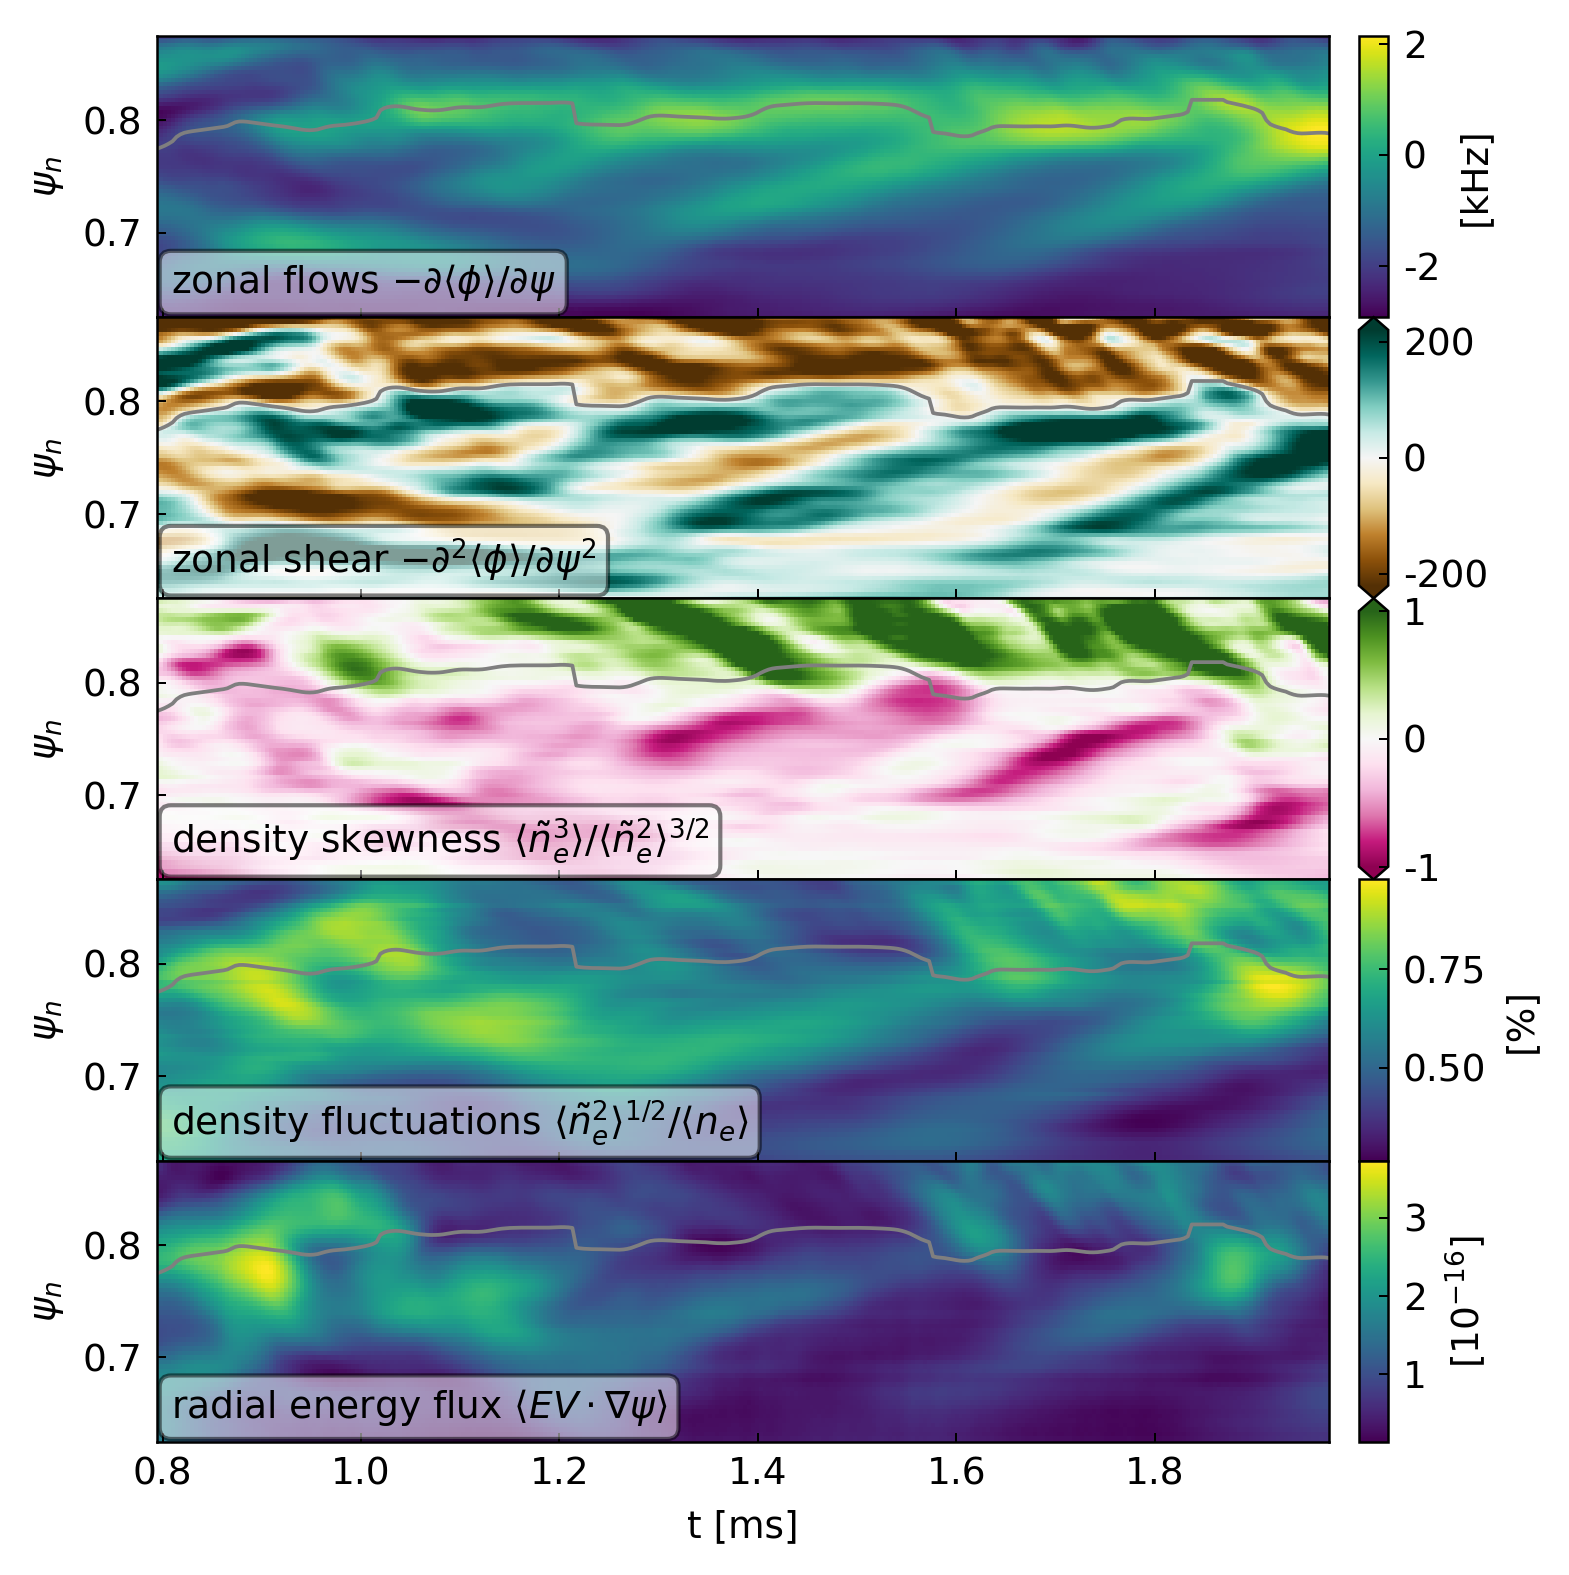

In [ ]:
# %% Individual hovmoller plots

#cax_inset = [0.01, 0.3, 0.3, 0.15]
cb_props = {'orientation': 'vertical'}
text_bbox = {'facecolor': 'white',
             'alpha': 0.5,
             'boxstyle': 'round'}
text_props = {'x': 0.012, 'y': 0.05,
              'size': 9,
              'va': 'bottom', 'ha': 'left',
              'bbox': text_bbox}
psi_lim = (0.625,0.875)
t_lim = (t[200]*1e3, t[-1]*1e3)

def find_vlim(t, psi, field):
    """
    Finds the vmin and vmax for a given field inside the limits of t and psi
    """
    t_inds = np.searchsorted(t, t_lim)
    psi_inds = np.searchsorted(psi, psi_lim)
    field_masked = field[psi_inds[0]:psi_inds[1], t_inds[0]:t_inds[1]]
    vmin = np.nanmin(field_masked)
    vmax = np.nanmax(field_masked)
    return vmin, vmax

def plot_hovmoller_shearless_contours(ax: mpl.axes.Axes):
    ax.plot(t*1e3, psi_shearless/eq.psix, color='tab:gray')

    #ax.axhline(0.8, color='tab:gray', linestyle='--')

    #cont = ax.contour(t*1e3, zpot_psi/eq.psix, -dzfield.T*1e-3,
    #                  levels=[0], colors='tab:gray', alpha=0.5)
    
    pass

def plot_hovmoller(t, psi, field: np.ndarray, cmap, ax: mpl.axes.Axes, cax: mpl.axes.Axes, label: str, cax_label: str, vmin = None, vmax = None):
    ## Get limits for plotting
    vmin_data, vmax_data = find_vlim(t, psi, field)
    vmin = vmin_data if vmin is None else vmin
    vmax = vmax_data if vmax is None else vmax

    ## Adjust limits and set labels
    ax.set_ylim(psi_lim)
    ax.set_xlim(t_lim)
    ax.set_ylabel(R'$\psi_n$')
    ax.xaxis.set_tick_params(labelbottom=False)

    ## Plot the field
    pc = ax.pcolormesh(t, psi, field, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    
    ## Decorate with the shearless contours
    plot_hovmoller_shearless_contours(ax)

    ## Label the plots
    ax.text(s=label, transform=ax.transAxes, **text_props)

    # Determine which ends of the colorbar to extend
    if vmin > vmin_data:
        if vmax < vmax_data:
            extend = 'both'
        else:
            extend = 'min'
    else:
        if vmax < vmax_data:
            extend = 'max'
        else:
            extend = 'neither'

    plt.colorbar(pc, cax=cax, label=cax_label, extend=extend, **cb_props)

## Test plots

fig = plt.figure(figsize=(5.3, 5.3), dpi=300)
gs = mpl.gridspec.GridSpec(5, 2, figure=fig, width_ratios=[1, 0.025])

row = 0
ax, cax = fig.add_subplot(gs[row,0]), fig.add_subplot(gs[row,1])
plot_hovmoller(t*1e3, zpot_psi/eq.psix, -zfield.T*1e-3,
           cmap='viridis', ax=ax, cax=cax,
           label=R'zonal flows $-\partial \langle\phi\rangle / \partial \psi$',
           cax_label=R'[kHz]', vmin=None, vmax=None)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
plot_hovmoller(t*1e3, zpot_psi/eq.psix, -dzfield.T*1e-3,
           cmap='BrBG', ax=ax, cax=cax,
           label=R'zonal shear $-\partial^2 \langle\phi\rangle / \partial \psi^2$',
           cax_label=R'', vmin=-220, vmax=220)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
e_den_fluct = np.sqrt(summary_data['e_den_var']/summary_data['e_den_avg']**2)
plot_hovmoller(t*1e3, geom.psi_surf/eq.psix, e_den_fluct.T*100,
           cmap='viridis', ax=ax, cax=cax,
           label=R'density fluctuations $\langle \tilde{n}_e^2 \rangle^{1/2} / \langle n_e \rangle$',
           cax_label=R'[%]', vmin=None, vmax=None)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
plot_hovmoller(t*1e3, psi_mks/eq.psix, (i_en_flux*1e16).T,
           cmap='viridis', ax=ax, cax=cax,
           label=R'radial energy flux $\langle E V \cdot \nabla \psi \rangle$',
           cax_label=R'$[10^{-16}]$', vmin=None, vmax=None)

row += 1
ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
e_den_skwn = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
plot_hovmoller(t*1e3, geom.psi_surf/eq.psix, e_den_skwn.T,
           cmap='PiYG', ax=ax, cax=cax,
           label=R'density skewness $\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$',
           cax_label=R'', vmin=-1, vmax=1)

#row += 1
#ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
#e_gc_lne = -np.gradient(np.log(e_gc_den), axis=1) / np.gradient(psi_mks)
#plot_hovmoller(t*1e3, psi_mks/eq.psix, e_gc_lne.T,
#           cmap='viridis', ax=ax, cax=cax,
#           label=R'electron density gradient',
#           cax_label=R'', vmin=None, vmax=None)
#
#row += 1
#ax, cax = fig.add_subplot(gs[row,0], sharex=ax), fig.add_subplot(gs[row,1])
#i_T_perp_lne = -np.gradient(np.log(i_T_perp), axis=1) / np.gradient(psi_mks)
#plot_hovmoller(t*1e3, psi_mks/eq.psix, i_T_perp_lne.T,
#           cmap='viridis', ax=ax, cax=cax,
#           label=R'ion temp gradient',
#           cax_label=R'', vmin=None, vmax=None)

ax.xaxis.set_tick_params(labelbottom=True)
ax.set_xlabel(R't [ms]')

plt.tight_layout(h_pad=0.0, w_pad=0.8)
plt.subplots_adjust(hspace=0.0)

plt.savefig('./outputs/jpp_figures/hovmoller_shearless.pdf', dpi=300)
plt.savefig('./outputs/jpp_figures/hovmoller_shearless.png', dpi=300)


## Poloidal Cross-Section Plots

In [155]:
# %% Load fluctuation data and compute the upsampled FFT of the potential

## Load the potential
tind = 400
dpot = xgcdata['dpot'][tind,:,:]

# Compute the upsampled FFT of the potential
dpot_fft = upsample_fft_dpot(dpot, geom)

In [ ]:
# %% Load poincare section data

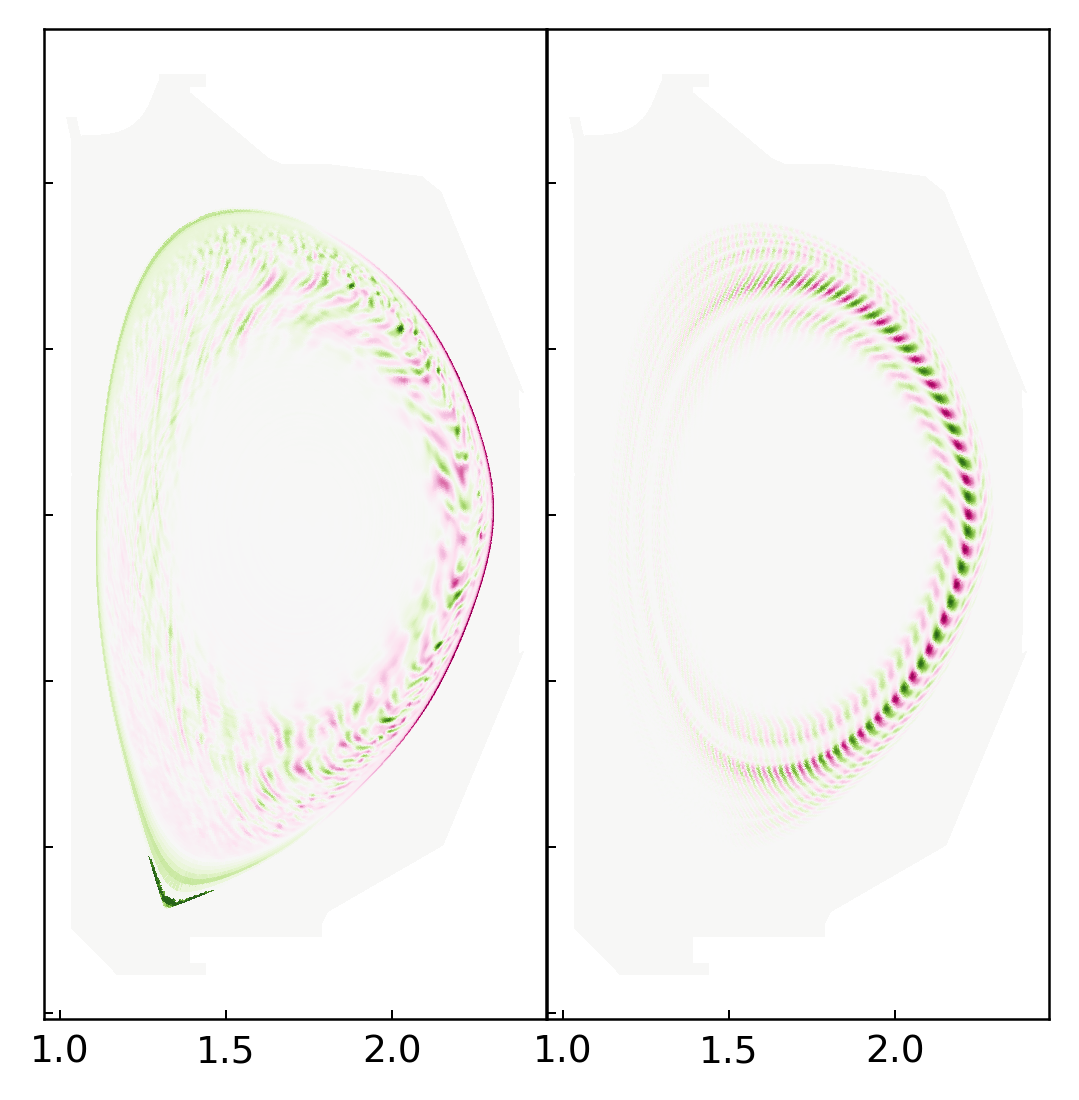

In [ ]:
# %% Plot the potential fields

def plot_poloidal_dpot(ax: mpl.axes.Axes):
    ax.set_aspect('equal')
    ax.yaxis.set_tick_params(labelleft=False)

    ax.tripcolor(geom.rz_tri, dpot[0,:], cmap='PiYG', vmin=-20, vmax=20)

def plot_poloidal_dpot_fft(ax: mpl.axes.Axes):
    ax.set_aspect('equal')
    ax.yaxis.set_tick_params(labelleft=False)

    ax.tripcolor(geom.rz_tri, np.real(dpot_fft[13,:]), cmap='PiYG')

fig = plt.figure(figsize=(5.3,4.0), dpi=300)
gs = mpl.gridspec.GridSpec(1, 3, figure=fig)

col = 0
ax = fig.add_subplot(gs[col])
plot_poloidal_dpot(ax)

col += 1
ax = fig.add_subplot(gs[col], sharex=ax, sharey=ax)
plot_poloidal_dpot_fft(ax)

plt.tight_layout(h_pad=0.0, w_pad=0.0)

In [ ]:
# %% Compute the cross-field drifts 